In [83]:
import msprime
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import scipy.integrate as integrate
import math
import pickle
import pandas as pd
from sklearn.neighbors.kde import KernelDensity
from sklearn.mixture import GaussianMixture

In [85]:
mut_effects = pd.read_csv('../data/yeast_expression/Trans.Mutation.Effects.txt', sep="\t")
log_effects = np.array(np.log2(mut_effects["MEAN"]))[:,np.newaxis]
gauss_mix_3 = GaussianMixture(n_components=3, max_iter=10000).fit(log_effects)

In [90]:
gauss_mix_sample = lambda size: gauss_mix_3.sample(size)[0][:,0]

In [2]:
def rho(j, t, eta):
    return np.exp(-scipy.special.binom(int(j), 2)*integrate.quad(eta, 0, t, limit=100)[0])

def comb_term(j, k, n):
    assert j >= k, "invalid integers"
    return ((-1)**(j-k)*(2*j - 1)*np.prod(list(range(k, k + j -1)))*
            np.prod(list(range(n, n - j, -1)))/
            (math.factorial(k)*math.factorial(j - k)*
             np.prod(list(range(n, n + j)))))

def P_Ant(k, t, n, eta):
    result = 0
    for jj in range(k, n + 1):
        result += (rho(jj, t, eta)*
                   comb_term(jj, k , n))
    return result

def ETj(k, n, eta):
    PP = lambda t: P_Ant(k, t, n, eta)
    return integrate.quad(PP, 0, scipy.inf, limit=100)

In [91]:
def full_pop_reps(Ne_sim, mu, pi, rr=0.0):
    genotypes = []
    c_rate = lambda t: np.exp(rr*2.*Ne_sim*t)
    T2_2 = ETj(2, 2, c_rate)[0] # get the expected pairwise coal time in units of 2Ne
    LL = round(pi / (4.*mu*Ne_sim*T2_2)) # calculate the necessary number of sites
    #print(LL)
    replicates = msprime.simulate(
        mutation_rate=mu,
        num_replicates=LL,
        population_configurations = [msprime.PopulationConfiguration(growth_rate=rr,
                                                                     sample_size=2*Ne_sim,
                                                                     initial_size=Ne_sim)])
    for j, tree_sequence in enumerate(replicates):
        #if not j % 1000:
            #print(j / LL)
        if tree_sequence.get_num_mutations() > 0:
            variant = next(tree_sequence.variants())
            genotypes.append(variant.genotypes)
        if tree_sequence.get_num_mutations() > 1:
            print("Warning: more than one mutation")
    return(np.array(genotypes, dtype=np.int32))

def full_pop_reps_fast(Ne_sim, mu, pi):
    genotypes = []
    replicates = msprime.simulate(
        sample_size=2*Ne_sim, # the coal rate is determined by two times Ne
        Ne=Ne_sim,
        mutation_rate=mu,
        num_replicates=round(pi / (4.*mu*Ne_sim)))
    for j, tree_sequence in enumerate(replicates):
        if tree_sequence.get_num_mutations() > 0:
            variant = next(tree_sequence.variants())
            genotypes.append(variant.genotypes)
        if tree_sequence.get_num_mutations() > 1:
            print("Warning: more than one mutation")
    return(np.array(genotypes, dtype=np.int32))

def nt_div(genotypes):
    result = 0
    psum = 0
    for ii in range(genotypes.shape[1]):
        for jj in range(ii+1, genotypes.shape[1]):
            result += np.sum(np.abs(genotypes[:,ii] - genotypes[:,jj]))
            psum += 1
    return result/psum

def phen_pop(Ne_sim, mu, pi, rr=0.0):
    genotypes = np.transpose(full_pop_reps(Ne_sim, mu, pi, rr=rr))
    while len(genotypes.shape) == 1:
        genotypes = np.transpose(full_pop_reps(Ne_sim, mu, pi, rr=rr))
    return(genotypes * gauss_mix_sample(size=genotypes.shape[1]))

def pop_kurt(phenotypes):
    phens = np.sum(phenotypes, axis=1)
    mean_phen = np.mean(phens)
    m4 = np.mean((phens - mean_phen)**4)
    m2 = np.var(phens)
    return(m4 / m2**2)

def pop_var(phenotypes):
    phens = np.sum(phenotypes, axis=1)
    return(np.var(phens))

def pop_m4(phenotypes):
    phens = np.sum(phenotypes, axis=1)
    mean_phen = np.mean(phens)
    m4 = np.mean((phens - mean_phen)**4)
    return(m4)

def pop_kurt_alt(phens):
    mean_phen = np.mean(phens)
    m4 = np.mean((phens - mean_phen)**4)
    m2 = np.var(phens)
    return(m4 / m2**2)

def var_sq(phenotypes):
    phens = np.sum(phenotypes, axis=1)
    return(np.var(phens)**2)

In [92]:
pi_set = [0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0]
nreps = [500, 500, 500, 500, 400, 300, 200, 100]

In [233]:
pop_test = np.sum(phen_pop(1000, 5e-7, 10), axis=1)

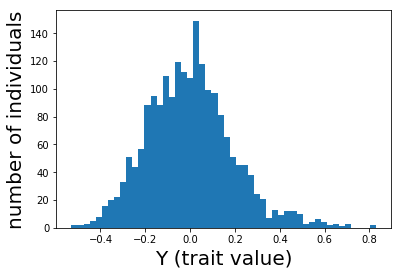

In [241]:
fig, ax = plt.subplots(facecolor = 'w', figsize=(6, 4));
plt.hist(pop_test - np.mean(pop_test), bins = 50);
plt.xlabel("Y (trait value)", fontsize = 20)
plt.ylabel("number of individuals", fontsize = 20)
plt.savefig("dist_example_yeast.pdf", bbox_inches="tight")

In [235]:
M1 = np.mean(pop_test)
M1

0.031165511294244993

In [236]:
M2 = np.var(pop_test)
M2

0.0370435845309297

In [237]:
M3 = np.mean([(xx-M1)**3 for xx in pop_test])
M3

0.0036010893151793262

In [238]:
M3/ M2**(1.5)

0.5050849011236695

In [239]:
M4 = np.mean([(xx-M1)**4 for xx in pop_test])
M4

0.00517026806568493

In [240]:
M4 / M2**2

3.767793143593055

In [242]:
3*M2**2

0.004116681464700402

In [95]:
sim_phens = []
for ii, pi in enumerate(pi_set):
    print(pi)
    sim_phens.append([])
    for jj in range(nreps[ii]):
        sim_phens[ii].append(phen_pop(1000, 1e-6, pi))

0.5


KeyboardInterrupt: 

In [ ]:
#sim_phens_growth = []
#for ii, pi in enumerate(pi_set):
#    print(pi)
#    sim_phens_growth.append([])
#    for jj in range(nreps[ii]):
#        sim_phens_growth[ii].append(phen_pop(test_Ne, 1e-6, pi, rr=test_rr))

In [ ]:
#sim_phens_growth_lap = []
#for ii, pi in enumerate(pi_set):
#    print(pi)
#    sim_phens_growth_lap.append([])
#    for jj in range(nreps[ii]):
#        sim_phens_growth_lap[ii].append(phen_pop(test_Ne, 1e-6, pi, rr=test_rr))

In [76]:
#with open("sim_phens_norm.pyc", "wb") as fout:
#    pickle.dump(sim_phens, file=fout)

In [133]:
#with open("sim_phens_norm_growth.pyc", "wb") as fout:
#    pickle.dump(sim_phens_growth, file=fout)

In [136]:
#with open("sim_phens_lap_growth.pyc", "wb") as fout:
#    pickle.dump(sim_phens_growth_lap, file=fout)

These simulations take a good amount of time to run so read in output already computed:

In [5]:
with open("sim_phens_norm.pyc", "rb") as fin:
     sim_phens_norm = pickle.load(fin)

In [6]:
with open("sim_phens_lap.pyc", "rb") as fin:
    sim_phens_lap = pickle.load(fin)

In [7]:
with open("sim_phens_norm_growth.pyc", "rb") as fin:
    sim_phens_growth_norm = pickle.load(fin)

In [8]:
with open("sim_phens_lap_growth.pyc", "rb") as fin:
    sim_phens_growth_lap = pickle.load(fin)

In [15]:
pop_vars = np.array([np.mean([np.var(np.sum(pp, 1)) for pp in phen]) for phen in sim_phens])
pop_mkurts = np.array([np.mean([pop_kurt_alt(np.sum(pp, 1)) for pp in phen]) for phen in sim_phens])
pop_var_vars = np.array([np.var([np.var(np.sum(pp, 1)) for pp in phen], ddof=1) for phen in sim_phens])

In [16]:
pop_kurtsem = [stats.sem([pop_kurt_alt(np.sum(pp, 1)) for pp in phen]) for phen in sim_phens]

In [17]:
pop_var_vars

array([ 0.10680183,  0.23308137,  0.43084529,  0.45068593,  0.59410291,
        0.94221744,  1.40964672,  2.6113167 ])

In [9]:
pop_kurts_norm = []
for ii, pi in enumerate(pi_set):
    pop_kurts_norm.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_kurts_norm[ii][jj] = pop_kurt(sim_phens_norm[ii][jj])

In [10]:
pop_kurts_lap = []
for ii, pi in enumerate(pi_set):
    pop_kurts_lap.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_kurts_lap[ii][jj] = pop_kurt(sim_phens_lap[ii][jj])

In [11]:
pop_kurts_growth_lap = []
for ii, pi in enumerate(pi_set):
    pop_kurts_growth_lap.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_kurts_growth_lap[ii][jj] = pop_kurt(sim_phens_growth_lap[ii][jj])

In [12]:
pop_kurts_growth_norm = []
for ii, pi in enumerate(pi_set):
    pop_kurts_growth_norm.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_kurts_growth_norm[ii][jj] = pop_kurt(sim_phens_growth_norm[ii][jj])

In [13]:
ET4_4 = ETj(4, 4, lambda t: np.exp(t))[0]
ET3_4 = ETj(3, 4, lambda t: np.exp(t))[0]
ET2_4 = ETj(2, 4, lambda t: np.exp(t))[0]
ET2_2 = ETj(2, 2, lambda t: np.exp(t))[0]
AA = (ET4_4 - (1./6.)*ET3_4 - (1./9.)*ET2_4)/ET2_2
BB = ((1./6.)*ET3_4 + (1./9.)*ET2_4)/ET2_2

/home/evankoch/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
/home/evankoch/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/evankoch/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/home/evankoch/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [14]:
print(AA, BB)

0.09231479183805001 0.1512808680269911


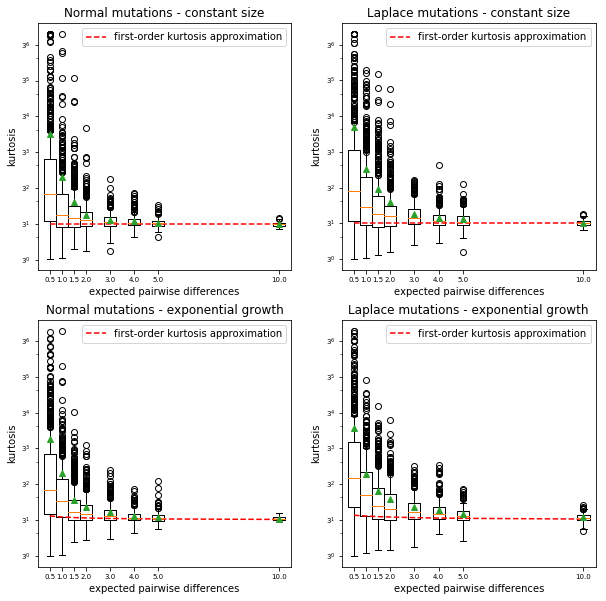

In [187]:
plt.figure(1, figsize=(10, 10))
plt.subplot(221)
plt.boxplot(pop_kurts_norm, positions=pi_set, showmeans=True);
plt.plot(pi_set, [3]*len(pi_set), "--r", label="first-order kurtosis approximation")
plt.tick_params(labelsize=7)
plt.yscale("log", basey=3)
plt.xlabel("expected pairwise differences")
plt.ylabel("kurtosis")
plt.legend()
plt.title("Normal mutations - constant size")

plt.subplot(222)
plt.boxplot(pop_kurts_lap, positions=pi_set, showmeans=True);
plt.plot(pi_set, [3]*len(pi_set), "--r", label="first-order kurtosis approximation")
plt.tick_params(labelsize=7)
plt.yscale("log", basey=3)
plt.xlabel("expected pairwise differences")
plt.ylabel("kurtosis")
plt.legend()
plt.title("Laplace mutations - constant size")

plt.subplot(224)
plt.boxplot(pop_kurts_growth_lap, positions=pi_set, showmeans=True);
plt.plot(pi_set, 3 + 6.*AA/(0.5*np.array(pi_set) + 6.*BB), "--r", label="first-order kurtosis approximation")
plt.tick_params(labelsize=7)
plt.yscale("log", basey=3)
plt.xlabel("expected pairwise differences")
plt.ylabel("kurtosis")
plt.legend()
plt.title("Laplace mutations - exponential growth")

plt.subplot(223)
plt.boxplot(pop_kurts_growth_norm, positions=pi_set, showmeans=True);
plt.plot(pi_set, 3 + 3.*AA/(0.5*np.array(pi_set) + 3.*BB), "--r", label="first-order kurtosis approximation")
plt.tick_params(labelsize=7)
plt.yscale("log", basey=3)
plt.xlabel("expected pairwise differences")
plt.ylabel("kurtosis")
plt.legend()
plt.title("Normal mutations - exponential growth")
plt.savefig("norm_growth_kurt_sim.pdf", bbox_inches="tight")
plt.savefig("kurt_sim.pdf", bbox_inches="tight")

In [15]:
pop_vars_norm = []
for ii, pi in enumerate(pi_set):
    pop_vars_norm.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_vars_norm[ii][jj] = pop_var(sim_phens_norm[ii][jj])

pop_vars_lap = []
for ii, pi in enumerate(pi_set):
    pop_vars_lap.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_vars_lap[ii][jj] = pop_var(sim_phens_lap[ii][jj])

pop_vars_growth_lap = []
for ii, pi in enumerate(pi_set):
    pop_vars_growth_lap.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_vars_growth_lap[ii][jj] = pop_var(sim_phens_growth_lap[ii][jj])

pop_vars_growth_norm = []
for ii, pi in enumerate(pi_set):
    pop_vars_growth_norm.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_vars_growth_norm[ii][jj] = pop_var(sim_phens_growth_norm[ii][jj])

Text(0.5,1,'Normal mutations - constant size')

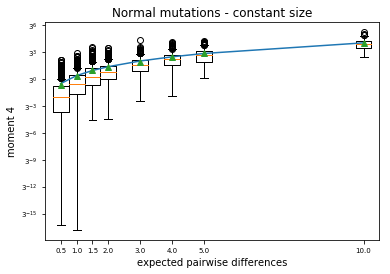

In [65]:
plt.boxplot(np.array(pop_m4s_norm), positions=pi_set, showmeans=True);
plt.plot(pi_set, [3]*(np.array(pi_set)/2.0)**2 + [3]*(np.array(pi_set)/4.0))
plt.tick_params(labelsize=7)
plt.yscale("log", basey=3)
plt.xlabel("expected pairwise differences")
plt.ylabel("moment 4")
plt.legend()
plt.title("Normal mutations - constant size")

Text(0.5,1,'Normal mutations - constant size')

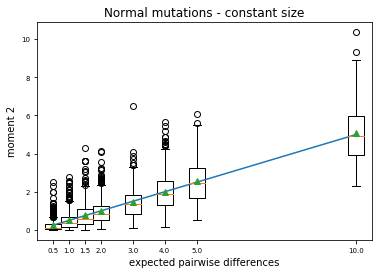

In [50]:
plt.boxplot(pop_vars_norm, positions=pi_set, showmeans=True);
plt.plot(pi_set, np.array(pi_set)/2.0 )
plt.tick_params(labelsize=7)
#plt.yscale("log", basey=10)
plt.xlabel("expected pairwise differences")
plt.ylabel("moment 2")
plt.legend()
plt.title("Normal mutations - constant size")

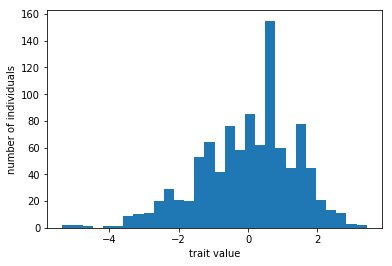

In [101]:
fig, ax = plt.subplots(facecolor = 'w', figsize=(6, 4));
phens = np.sum(sim_phens_norm[6][26], axis=1)
phens -= np.mean(phens)
plt.hist(phens, bins = 30);
plt.xlabel("trait value")
plt.ylabel("number of individuals")
plt.savefig("dist_example_1.pdf", bbox_inches="tight")

In [100]:
np.sum(sim_phens_norm[6][26], axis=1).shape

(1000,)

In [78]:
np.mean([phen**2 for phen in phens])

1.920516669212554

In [79]:
np.mean([phen**3 for phen in phens])

-1.4098916776076416

In [80]:
np.mean([phen**4 for phen in phens])

11.955362814416967

In [81]:
np.mean([phen**4 for phen in phens]) / np.mean([phen**2 for phen in phens])**2

3.241354999224206

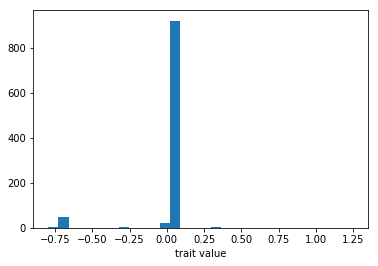

In [80]:
phens = np.sum(sim_phens_norm[0][20], axis=1)
phens -= np.mean(phens)
plt.hist(phens, bins = 30);
plt.xlabel("trait value")
plt.savefig("dist_example_2.pdf", bbox_inches="tight")

In [18]:
pop_m4s_norm = []
for ii, pi in enumerate(pi_set):
    pop_m4s_norm.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_m4s_norm[ii][jj] = pop_m4(sim_phens_norm[ii][jj])

pop_m4s_lap = []
for ii, pi in enumerate(pi_set):
    pop_m4s_lap.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_m4s_lap[ii][jj] = pop_m4(sim_phens_lap[ii][jj])

pop_m4s_growth_lap = []
for ii, pi in enumerate(pi_set):
    pop_m4s_growth_lap.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_m4s_growth_lap[ii][jj] = pop_m4(sim_phens_growth_lap[ii][jj])

pop_m4s_growth_norm = []
for ii, pi in enumerate(pi_set):
    pop_m4s_growth_norm.append([0]*nreps[ii])
    for jj in range(nreps[ii]):
        pop_m4s_growth_norm[ii][jj] = pop_m4(sim_phens_growth_norm[ii][jj])

In [77]:
np.mean(np.array(pop_m4s_norm[5]) - 3*np.array(pop_vars_norm[5])**2)

0.042287474505167046

In [73]:
3*(1/4)**2

0.1875

In [35]:
np.mean(np.array(pop_vars_norm[7]))

5.0596000916084645

In [38]:
3*5**2

75

In [39]:
np.mean(np.array(pop_m4s_norm[7])) - 75

8.4709718987634375

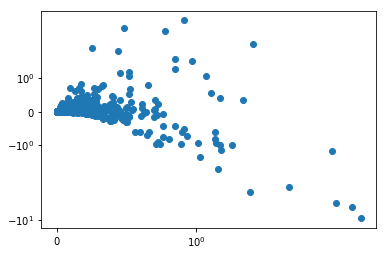

In [57]:
plt.plot(pop_vars_norm[0], np.array(pop_m4s_norm[0]) - 3*np.array(pop_vars_norm[0])**2, "o")
plt.yscale("symlog", basey=10)
plt.xscale("symlog", basey=10)

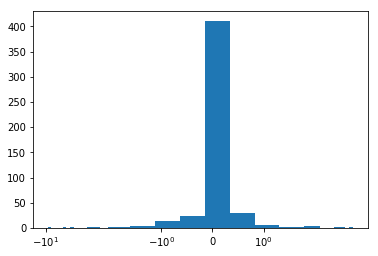

In [71]:
plt.hist(np.array(pop_m4s_norm[0]) - 3*np.array(pop_vars_norm[0])**2, bins = 30);
plt.xscale("symlog", basey=10)

In [154]:
corrs_norm = []
for ii, pi in enumerate(pi_set):
    corrs_norm.append(scipy.stats.spearmanr(np.array(pop_vars_norm[ii])**2, 
                                            pop_m4s_norm[ii])[0])
    
corrs_lap = []
for ii, pi in enumerate(pi_set):
    corrs_lap.append(scipy.stats.spearmanr(np.array(pop_vars_lap[ii])**2, 
                                           pop_m4s_lap[ii])[0])
corrs_growth_norm = []
for ii, pi in enumerate(pi_set):
    corrs_growth_norm.append(scipy.stats.spearmanr(np.array(pop_vars_growth_norm[ii])**2, 
                                            pop_m4s_growth_norm[ii])[0])
corrs_growth_lap = []
for ii, pi in enumerate(pi_set):
    corrs_growth_lap.append(scipy.stats.spearmanr(np.array(pop_vars_growth_lap[ii])**2, 
                                            pop_m4s_growth_lap[ii])[0])

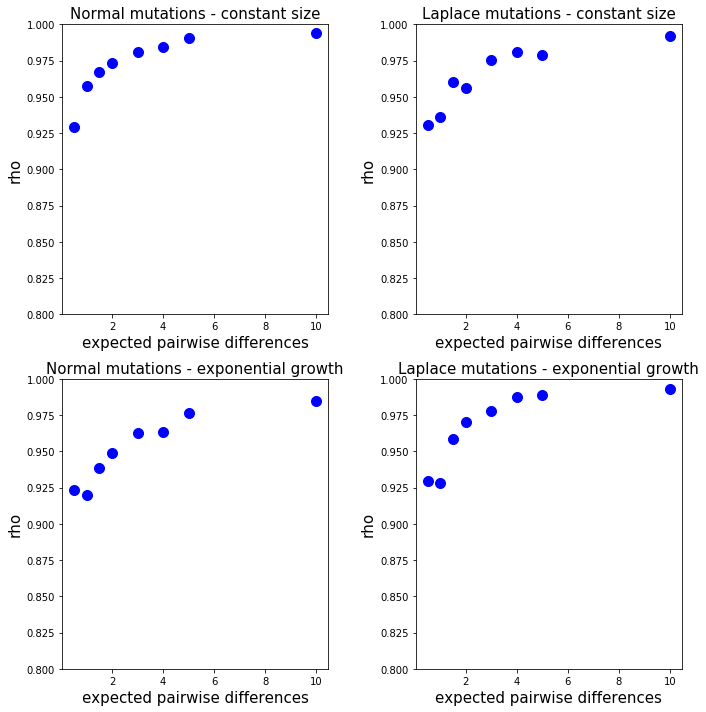

In [155]:
fntsize = 15
y1 = .8
y2 = 1

plt.figure(1, figsize=(10, 10))
plt.subplot(221)
plt.plot(pi_set, corrs_norm, "bo", ms = 10)
plt.ylim(y1,y2)
plt.xlabel("expected pairwise differences", fontsize = fntsize)
plt.ylabel("rho", fontsize = fntsize)
plt.title("Normal mutations - constant size", fontsize = fntsize)
plt.subplot(222)
plt.plot(pi_set, corrs_lap, "bo", ms = 10)
plt.ylim(y1,y2)
plt.xlabel("expected pairwise differences", fontsize = fntsize)
plt.ylabel("rho", fontsize = fntsize)
plt.title("Laplace mutations - constant size", fontsize = fntsize)
plt.subplot(224)
plt.plot(pi_set, corrs_growth_norm, "bo", ms = 10)
plt.ylim(y1,y2)
plt.xlabel("expected pairwise differences", fontsize = fntsize)
plt.ylabel("rho", fontsize = fntsize)
plt.title("Laplace mutations - exponential growth", fontsize = fntsize)
plt.subplot(223)
plt.plot(pi_set, corrs_growth_lap, "bo", ms = 10)
plt.ylim(y1,y2)
plt.xlabel("expected pairwise differences", fontsize = fntsize)
plt.ylabel("rho", fontsize = fntsize)
plt.title("Normal mutations - exponential growth", fontsize = fntsize)
#plt.subplots_adjust(hspace = .3, wspace = .3)
plt.tight_layout()
plt.savefig("kurt_corr.pdf", bbox_inches="tight")

/home/evankoch/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


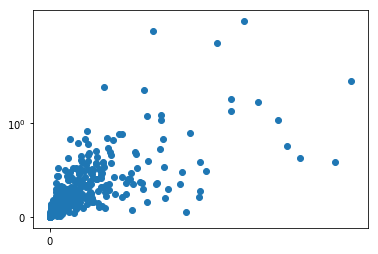

In [160]:
plt.scatter(np.power(pop_vars_norm[0],2), pop_m4s_norm[0] - 3*np.power(pop_vars_norm[0],2))
plt.yscale("symlog")
plt.xscale("symlog")

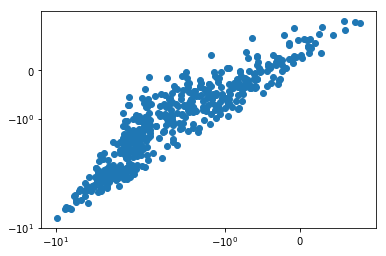

In [162]:
plt.scatter(np.log10(np.power(pop_vars_norm[0],2)), np.log10(pop_m4s_norm[0]))
plt.yscale("symlog")
plt.xscale("symlog")

1.4876996463791701

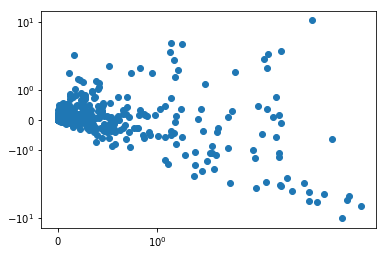

In [149]:
plt.scatter(np.power(pop_vars_norm[1],2), np.array(pop_m4s_norm[1]) - np.array(3*np.power(pop_vars_norm[1],2)))
plt.yscale("symlog")
plt.xscale("symlog")
np.mean(np.array(pop_m4s_norm[1]))

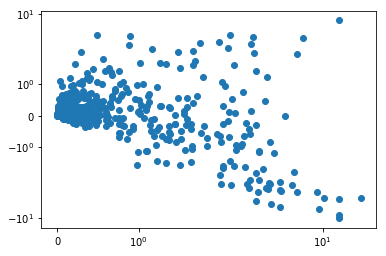

In [150]:
plt.scatter(np.power(pop_vars_norm[2],2), np.array(pop_m4s_norm[2]) - np.array(3*np.power(pop_vars_norm[2],2)))
plt.yscale("symlog")
plt.xscale("symlog")

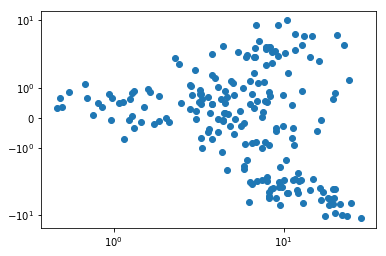

In [151]:
plt.scatter(np.power(pop_vars_norm[6],2), np.array(pop_m4s_norm[6]) - np.array(3*np.power(pop_vars_norm[6],2)))
plt.yscale("symlog")
plt.xscale("symlog")